# Title of notebook

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Imports of all used packages and libraries
import os
import glob
import bisect

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy.signal import butter, filtfilt, hilbert
import matplotlib

In [3]:
from itertools import product

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp

In [5]:
from sklearn import preprocessing as pre



In [6]:
import math

In [7]:
from collections import defaultdict

In [8]:
import numpy as np
from astropy.stats import rayleightest
from astropy import units as u


## Inputs & Data

Explanation of each input and where it comes from.

In [9]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [10]:
MERGED_SPIKE_TRIAL_DF = pd.read_csv("../2023_09_26_omission_lfp_analysis/proc/all_spike_time.csv")

In [11]:
BASIC_LFP_TRACES_DF = pd.read_pickle("../2023_09_26_omission_lfp_analysis/proc/full_baseline_and_trial_lfp_traces.pkl")

In [12]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000
LFP_SAMPLING_RATE=1000
EPHYS_SAMPLING_RATE=20000
TRIAL_DURATION=10

In [13]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [14]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "red",
 'omission': "orange",
 'rewarded': "green",
 'win': "blue"}


OUTCOME_TO_COLOR = {'lose': "#951a1d",
 'omission': "#af780d",
 'rewarded': "#0499af",
 'win': "#3853a3",
                   "significant": "#FFAF00",
                   "not significant": "#800000", 
                   "multiple conditions": "#15616F"}

# Yellow #FFAF00; teal #15616F

In [15]:
BAND_TO_FREQUENCY = {"theta": {"FREQ": (6,10)}, "gamma": {"FREQ": (30,90)}}
                     # , "beta": {"FREQ": (12,30)}, "gamma": {"FREQ": (30,90)}}

In [16]:
ORDER=4

In [17]:
for key, value in BAND_TO_FREQUENCY.items():
    BAND_TO_FREQUENCY[key]["numerator_b_and_denominator_a"] = butter(ORDER, value["FREQ"], fs=LFP_SAMPLING_RATE, btype='band')

In [18]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

# Functions

In [19]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [20]:
def PPC(spike_phases):
    sp_complex = map(lambda x: [math.cos(x), math.sin(x)], spike_phases)
    all_com = list(itertools.combinations(sp_complex , 2))
    dp_array = np.empty(int(len(spike_phases) * (len(spike_phases) - 1) / 2))
    for d, combination in enumerate(all_com):
        dp = np.dot(combination[0], combination[1])
        dp_array[d] = dp
    dp_sum = np.sum(dp_array)
    ppc = dp_sum / len(dp_array)
    return ppc


In [21]:

def find_closest_nums(list1, list2):
    """
    For each number in list1, find the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of closest numbers from list2 for each number in list1.
    """
    closest_nums = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return it
        if position != len(list2) and list2[position] == num:
            closest_nums.append(num)
        # Else find the closest of the two neighbors
        else:
            if position == 0:
                closest_nums.append(list2[0])
            elif position == len(list2):
                closest_nums.append(list2[-1])
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_nums.append(before if num - before <= after - num else after)

    return closest_nums



In [22]:
def find_closest_indices(list1, list2):
    """
    For each number in list1, find the index of the closest number in list2.

    Args:
    - list1 (list): An ORDERed list of numbers.
    - list2 (list): Another ORDERed list of numbers.

    Returns:
    - list: A list of indices of the closest numbers from list2 for each number in list1.
    """
    closest_indices = []

    for num in list1:
        # Find where the number would be inserted in list2
        position = bisect.bisect_left(list2, num)

        # If the number is actually present in list2, then return its index
        if position != len(list2) and list2[position] == num:
            closest_indices.append(position)
        # Else find the index of the closest of the two neighbors
        else:
            if position == 0:
                closest_indices.append(0)
            elif position == len(list2):
                closest_indices.append(len(list2) - 1)
            else:
                before = list2[position - 1]
                after = list2[position]
                closest_indices.append(position - 1 if num - before <= after - num else position)

    return closest_indices


In [23]:
def combine_hex_values(d):
  d_items = sorted(d.items())
  tot_weight = sum(d.values())
  red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
  green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
  blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
  zpad = lambda x: x if len(x)==2 else '0' + x
  return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])

# Processing

To help towards deciding how to calculate the phase locking, could you let me know what is the  num of spikes you have per trial condition? The a quick look to make sure that if we make a threshold to exclude low firing we do not end up excluding 50% of the cells. If there is too little spiking then we can focus on social vs alone comparison, and do whole session phase locking

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

## Getting the timestamps

- Getting a list of all the timestamps for LFP and spike for syncing with other data

In [24]:
BASIC_LFP_TRACES_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,mPFC_baseline_lfp_trace,mPFC_trial_lfp_trace,vHPC_baseline_lfp_trace,vHPC_trial_lfp_trace,BLA_baseline_lfp_trace,BLA_trial_lfp_trace,LH_baseline_lfp_trace,LH_trial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[1.8457601, 1.7363818, 1.6475118, 1.59738, 1.2...","[0.6927297, 0.96389693, 0.7884358, -0.04101689...","[-0.06969439, -0.09568214, -0.05315674, 0.1571...","[1.5864334, 1.5710771, 1.5970649, 1.2155175, 0...","[2.0367627, 2.1163385, 2.1618104, 2.2679114, 2...","[0.3164087, 0.36377528, 0.18757163, -0.5020857...","[3.1382985, 3.2319791, 3.2788196, 3.2881875, 3...","[0.8118982, 1.2209699, 0.87435186, -0.4028264,...","[1.3934726, 1.494771, 1.764077, 1.828315, 1.68...","[-0.9783956, -0.86721426, -0.7288553, -1.40582..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[1.2191132, 1.1348007, 1.2054409, 1.0960625, 0...","[1.0732753, 0.7246318, 0.7633699, 0.3782669, -...","[0.31539667, 0.23152715, 0.29767776, 0.4217101...","[0.03543783, -0.27641505, -0.40044746, -0.6638...","[0.3107247, 0.14209972, -0.05873455, -0.331566...","[0.026525281, -0.04547191, 0.11936376, -0.4092...","[-1.180375, -1.2959143, -1.3771042, -1.458294,...","[0.9492963, 0.46840277, 0.6713773, 0.043717593...","[-0.14577106, -0.16059524, 0.027177656, 0.1680...","[1.6281886, 1.349, 1.4675934, 0.9487473, -0.21..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-1.2669662, -1.2965895, -1.2532939, -0.986684...","[0.28711826, 0.84996116, 1.0960625, 0.8226166,...","[-1.2556804, -1.2580429, -1.3312811, -1.118654...","[0.060244307, 0.4748669, 0.7654571, 0.6591436,...","[-1.9912907, -1.9041362, -1.9325562, -1.542255...","[0.69344664, 1.4001559, 1.7582471, 1.4304705, ...","[-0.19985186, -0.074944444, -0.18423842, -0.13...","[-0.59643286, 0.27167362, 0.6901134, 0.4371759...","[-0.32119048, -0.52872896, -0.96851283, -0.753...","[0.096357144, 0.88450915, 1.2131118, 0.8943919..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[-2.0257788, -2.0348935, -1.9323514, -1.754611...","[2.376701, 2.3015034, 1.7796774, 0.9411098, 0....","[0.16655779, 0.42879772, 0.66268736, 0.6934002...","[-1.8427671, -2.303459, -2.6802812, -3.060647,...","[-1.2637402, -1.0382752, -0.82986236, -0.74649...","[2.6771586, 2.3929594, 2.209177, 1.9761335, 1....","[-2.538743, -2.1983705, -1.8673657, -1.7143542...","[2.8447661, 2.3045416, 1.5301157, 0.96490973, ...","[-2.7647088, -2.5546997, -2.3051593, -2.055619...","[2.087738, 1.7418406, 1.1266373, 0.45954946, 0..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.5765152, 0.25749493, 0.6403192, 0.4375135,...","[-0.043295607, 0.73602533, 0.31674156, 0.07747...","[-0.31421542, 0.19727057, 0.4453354, 0.3744597...","[0.21617076, 0.8221576, 0.58236164, 0.43116024...","[-2.1352851, -2.0576038, -2.0822346, -2.140969...","[-0.18188764, 0.113

In [25]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF.drop_duplicates(["recording_file", "time", "current_subject"])

In [26]:
BASIC_LFP_TRACES_DF["lfp_trial_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x,x+TRIAL_DURATION*LFP_SAMPLING_RATE))

BASIC_LFP_TRACES_DF["lfp_baseline_all_lfp_index"] = BASIC_LFP_TRACES_DF["lfp_index"].apply(lambda x: np.arange(x-TRIAL_DURATION*LFP_SAMPLING_RATE, x))

In [27]:
BASIC_LFP_TRACES_DF["lfp_trial_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x,x+EPHYS_SAMPLING_RATE*TRIAL_DURATION, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

BASIC_LFP_TRACES_DF["lfp_baseline_all_ephys_index"] = BASIC_LFP_TRACES_DF["time_stamp_index"].apply(lambda x: np.arange(x-EPHYS_SAMPLING_RATE*TRIAL_DURATION, x, int(EPHYS_SAMPLING_RATE/LFP_SAMPLING_RATE)))

# Syncing LFP and spikes

In [28]:
MERGED_SPIKE_TRIAL_DF.head()

,Unnamed: 0,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial
0,0,65,937,65,2,1,3,8.466800,2,0.0,40.0,2.628268,good,9014,0,8.0,20230618_100636_standard_comp_to_omission_D2_s...,NaN,NaN,11599246
1,1,123,998,123,1,1,1,19.984566,24,0.0,480.0,2.384219,good,8177,0,28.0,20230618_100636_standard_comp_to_omission_D2_s...,NaN,NaN,11599246
2,2,103,1125,103,12,2,32,14.402934,6,0.0,120.0,8.755451,good,30028,0,11.0,20230618_100636_standard_comp_to_omission_D2_s...,NaN,NaN,11599246
3,3,123,1327,123,1,1,1,19.984566,24,0.0,480.0,2.384219,good,8177,0,28.0,20230618_100636_standard_comp_to_omission_D2_s...,329.0,0.01645,11599246
4,4,103,1346,103,12,2,32,14.402934,6,0.0,120.0,8.755451,good,30028,0,11.0,20230618_100636_standard_comp_to_omission_D2_s...,221.0,0.01105,11599246


- Getting the ephys sample index from the start of the trial onset
    - i.e. the number of ephys samples that the spike fired compared to sample of the trial onset

In [29]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["spike_times"] - MERGED_SPIKE_TRIAL_DF["closest_trial"]


- Doing the same for LFP, but just downsampling from 20khz to 1khz

In [30]:
(EPHYS_SAMPLING_RATE // LFP_SAMPLING_RATE)

20

In [31]:
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"] = MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"] // (EPHYS_SAMPLING_RATE // LFP_SAMPLING_RATE)

- Removing all spikes that are not within the 10 second trial duration

In [32]:
MERGED_SPIKE_TRIAL_DF = MERGED_SPIKE_TRIAL_DF[np.abs(MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"]) <= TRIAL_DURATION * EPHYS_SAMPLING_RATE].reset_index(drop=True)

In [33]:
MERGED_SPIKE_TRIAL_DF["ephys_sample_from_trial_onset"].head()

0   -199973
1   -199830
2   -199448
3   -199250
4   -198540
Name: ephys_sample_from_trial_onset, dtype: int64

In [34]:
MERGED_SPIKE_TRIAL_DF["lfp_sample_from_trial_onset"].head()

0   -9999
1   -9992
2   -9973
3   -9963
4   -9927
Name: lfp_sample_from_trial_onset, dtype: int64

- Remaking the spike IDs to include file name
    - This is necessary because some spikes have the same ID number across files because they're just based on ID number that repeats with every spike sorting

In [35]:
MERGED_SPIKE_TRIAL_DF["cluster_id_with_file_name"] = MERGED_SPIKE_TRIAL_DF["cluster_id"].astype(str) + "_" + MERGED_SPIKE_TRIAL_DF["recording_name"]

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [36]:
BASIC_LFP_TRACES_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,BLA_baseline_lfp_trace,BLA_trial_lfp_trace,LH_baseline_lfp_trace,LH_trial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace,lfp_trial_all_lfp_index,lfp_baseline_all_lfp_index,lfp_trial_all_ephys_index,lfp_baseline_all_ephys_index
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[2.0367627, 2.1163385, 2.1618104, 2.2679114, 2...","[0.3164087, 0.36377528, 0.18757163, -0.5020857...","[3.1382985, 3.2319791, 3.2788196, 3.2881875, 3...","[0.8118982, 1.2209699, 0.87435186, -0.4028264,...","[1.3934726, 1.494771, 1.764077, 1.828315, 1.68...","[-0.9783956, -0.86721426, -0.7288553, -1.40582...","[69541, 69542, 69543, 69544, 69545, 69546, 695...","[59541, 59542, 59543, 59544, 59545, 59546, 595...","[1390826, 1390846, 1390866, 1390886, 1390906, ...","[1190826, 1190846, 1190866, 1190886, 1190906, ..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[0.3107247, 0.14209972, -0.05873455, -0.331566...","[0.026525281, -0.04547191, 0.11936376, -0.4092...","[-1.180375, -1.2959143, -1.3771042, -1.458294,...","[0.9492963, 0.46840277, 0.6713773, 0.043717593...","[-0.14577106, -0.16059524, 0.027177656, 0.1680...","[1.6281886, 1.349, 1.4675934, 0.9487473, -0.21...","[149541, 149542, 149543, 149544, 149545, 14954...","[139541, 139542, 139543, 139544, 139545, 13954...","[2990825, 2990845, 2990865, 2990885, 2990905, ...","[2790825, 2790845, 2790865, 2790885, 2790905, ..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-1.9912907, -1.9041362, -1.9325562, -1.542255...","[0.69344664, 1.4001559, 1.7582471, 1.4304705, ...","[-0.19985186, -0.074944444, -0.18423842, -0.13...","[-0.59643286, 0.27167362, 0.6901134, 0.4371759...","[-0.32119048, -0.52872896, -0.96851283, -0.753...","[0.096357144, 0.88450915, 1.2131118, 0.8943919...","[239541, 239542, 239543, 239544, 239545, 23954...","[229541, 229542, 229543, 229544, 229545, 22954...","[4790823, 4790843, 4790863, 4790883, 4790903, ...","[4590823, 4590843, 4590863, 4590883, 4590903, ..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[-1.2637402, -1.0382752, -0.82986236, -0.74649...","[2.6771586, 2.3929594, 2.209177, 1.9761335, 1....","[-2.538743, -2.1983705, -1.8673657, -1.7143542...","[2.8447661, 2.3045416, 1.5301157, 0.96490973, ...","[-2.7647088, -2.5546997, -2.3051593, -2.055619...","[2.087738, 1.7418406, 1.1266373, 0.45954946, 0...","[319541, 319542, 319543, 319544, 319545, 31954...","[309541, 309542, 309543, 309544, 309545, 30954...","[6390821, 6390841, 6390861, 6390881, 6390901, ...","[6190821, 6190841, 6190861, 6190881, 6190901, ..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-2.1352851, -2.0576038, -2.0822346, -2.140969...","[-0.18188764, 0.113679774, -0.66123736, -0.935...","[-2.1671436, -1.4832754, -1.0554676, -1.130412...","[0.5339792, 1.5113796, 0.57145137, -0.02810416...","[-2.0111465, -1.714663, -1.4255916, -1.3662949...","[0.

# Phase calculation

- Calculating the phase in degrees and radians

In [37]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [38]:
for trace_col, (band, value) in product(trace_columns, BAND_TO_FREQUENCY.items()):
    region_name = "_".join(trace_col.split("_")[:2])
    print(band, region_name)
    BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)] = BASIC_LFP_TRACES_DF[trace_col].apply(lambda x: filtfilt(value["numerator_b_and_denominator_a"][0], value["numerator_b_and_denominator_a"][1], x, padtype=None))
    
    BASIC_LFP_TRACES_DF["{}_{}_phase_radians".format(band, region_name)] = BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))

    BASIC_LFP_TRACES_DF["{}_{}_phase_degrees".format(band, region_name)] = BASIC_LFP_TRACES_DF["{}_{}_filtered".format(band, region_name)].apply(lambda x: np.angle(hilbert(x), deg=True))

theta mPFC_baseline
gamma mPFC_baseline
theta mPFC_trial
gamma mPFC_trial
theta vHPC_baseline
gamma vHPC_baseline
theta vHPC_trial
gamma vHPC_trial
theta BLA_baseline
gamma BLA_baseline
theta BLA_trial
gamma BLA_trial
theta LH_baseline
gamma LH_baseline
theta LH_trial
gamma LH_trial
theta MD_baseline
gamma MD_baseline
theta MD_trial
gamma MD_trial


In [39]:
BASIC_LFP_TRACES_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,theta_MD_baseline_phase_degrees,gamma_MD_baseline_filtered,gamma_MD_baseline_phase_radians,gamma_MD_baseline_phase_degrees,theta_MD_trial_filtered,theta_MD_trial_phase_radians,theta_MD_trial_phase_degrees,gamma_MD_trial_filtered,gamma_MD_trial_phase_radians,gamma_MD_trial_phase_degrees
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[124.4595429763872, 141.07390246461978, 142.23...","[0.04115775698493672, 0.11295380187572376, 0.1...","[-1.2855318441470045, -0.9143577729439708, -0....","[-73.65554909929288, -52.38884135467074, -32.6...","[-0.3194942774241363, -0.304396025623304, -0.2...","[2.6074996595573676, -3.0043265895311304, -2.9...","[149.39872557443616, -172.13523385906623, -168...","[-0.06335866385799732, -0.022468231799391763, ...","[-2.5419661952919865, -1.7454072291941767, -1....","[-145.64393465515843, -100.00446776444949, -75..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[142.6525041885258, 177.26427310038764, -179.7...","[-0.0903897354418438, -0.09704174941674733, -0...","[2.4911060919528394, 3.1039388936482557, -3.00...","[142.72986538822607, 177.84259847255115, -172....","[0.037630642935462255, 0.020604398694372195, 0...","[1.2914994813411182, 1.454539937086116, 1.5526...","[73.99746952418089, 83.33899952825874, 88.9628...","[0.0652597531108592, -0.04074664418442907, -0....","[0.9184400528995798, 1.7913540710530942, 2.362...","[52.62273876691798, 102.63702788492049, 135.36..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[131.08532941862214, 154.11387377060424, 155.3...","[-0.14491332090856698, -0.1314786579529695, -0...","[2.6342768860546695, -2.8140365484264476, -2.4...","[150.93294763979742, -161.23241762039694, -141...","[0.32434916974390937, 0.32233138764633296, 0.3...","[-0.7759614849836125, -0.2975671562717912, -0....","[-44.459318154265, -17.04934217608346, -15.063...","[0.04985940405473265, 0.09046372315808988, 0.1...","[-0.9770590376533174, -0.44320143405892515, -0...","[-55.981359192648874, -25.39357164572207, -1.0..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[-116.06831172743509, -102.42793212609777, -96...","[-0.29796191075925343, -0.21025925531419706, -...","[3.1024169743670087, -2.1927629506239206, -1.7...","[177.7553989209761, -125.63606254340398, -101....","[0.22803878841545244, 0.2296645716551549, 0.23...","[-0.9235665059870032, -0.5892114071348239, -0....","[-52.91646289269916, -33.75932686978985, -32.8...","[-0.1221915979466501, -0.2763996439260113, -0....","[2.0005709775727336, 2.455542238651779, 2.8586...","[114.62427363127891, 140.6922066908529, 163.78..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-58.75959768769791, -44.88577018927039, -43.5...","[-0.13981140887683305, -0.0859355465441699, -0...","[-3.0860632798902987, -2.085949282099884, -1.6...","[-176.81840124801423, -119.51609014266732, -95...",

- Plotting an example filtered trace

In [40]:
MERGED_SPIKE_TRIAL_DF.head()

,Unnamed: 0,spike_clusters,spike_times,cluster_id,1_5_ms_isi,1ms_isi,2ms_isi,amp,ch,channel_group,...,n_spikes,sh,si_unit_id,recording_name,timestamp_isi,current_isi,closest_trial,ephys_sample_from_trial_onset,lfp_sample_from_trial_onset,cluster_id_with_file_name
0,20759,103,11399273,103,12,2,32,14.402934,6,0.0,...,30028,0,11.0,20230618_100636_standard_comp_to_omission_D2_s...,183.0,0.00915,11599246,-199973,-9999,103_20230618_100636_standard_comp_to_omission_...
1,20760,83,11399416,83,9,3,26,13.022879,2,0.0,...,36640,0,5.0,20230618_100636_standard_comp_to_omission_D2_s...,1165.0,0.05825,11599246,-199830,-9992,83_20230618_100636_standard_comp_to_omission_D...
2,20761,65,11399798,65,2,1,3,8.466800,2,0.0,...,9014,0,8.0,20230618_100636_standard_comp_to_omission_D2_s...,7188.0,0.35940,11599246,-199448,-9973,65_20230618_100636_standard_comp_to_omission_D...
3,20762,103,11399996,103,12,2,32,14.402934,6,0.0,...,30028,0,11.0,20230618_100636_standard_comp_to_omission_D2_s...,723.0,0.03615,11599246,-199250,-9963,103_20230618_100636_standard_comp_to_omission_...
4,20763,103,11400706,103,12,2,32,14.402934,6,0.0,...,30028,0,11.0,20230618_100636_standard_comp_to_omission_D2_s...,710.0,0.03550,11599246,-198540,-9927,103_20230618_100636_standard_comp_to_omission_...


(0.0, 10000.0)

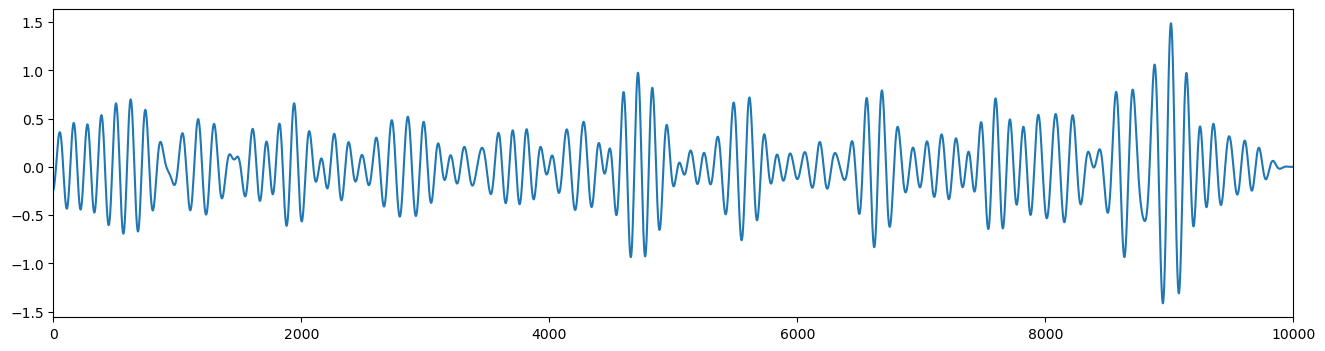

In [41]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_filtered"].iloc[0])

plt.xlim(0,10000)

(0.0, 10000.0)

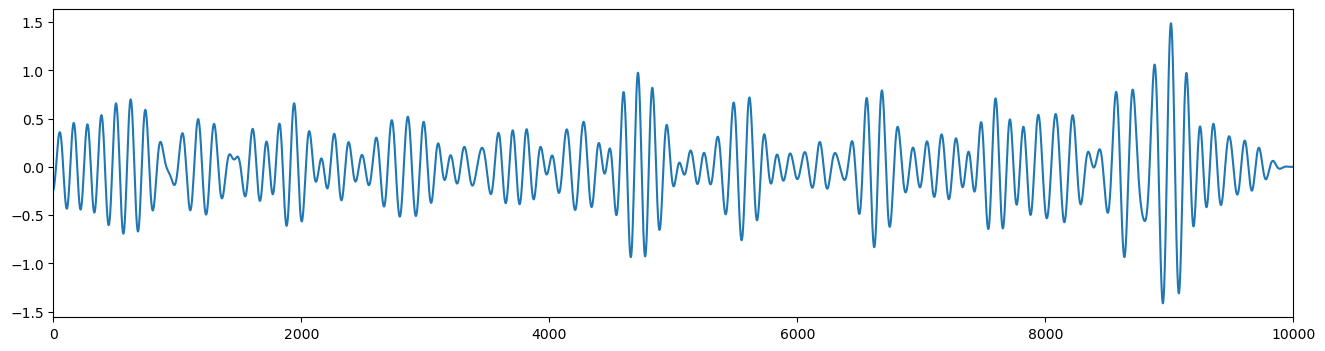

In [42]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_filtered"].iloc[0])

plt.xlim(0,10000)

(0.0, 10000.0)

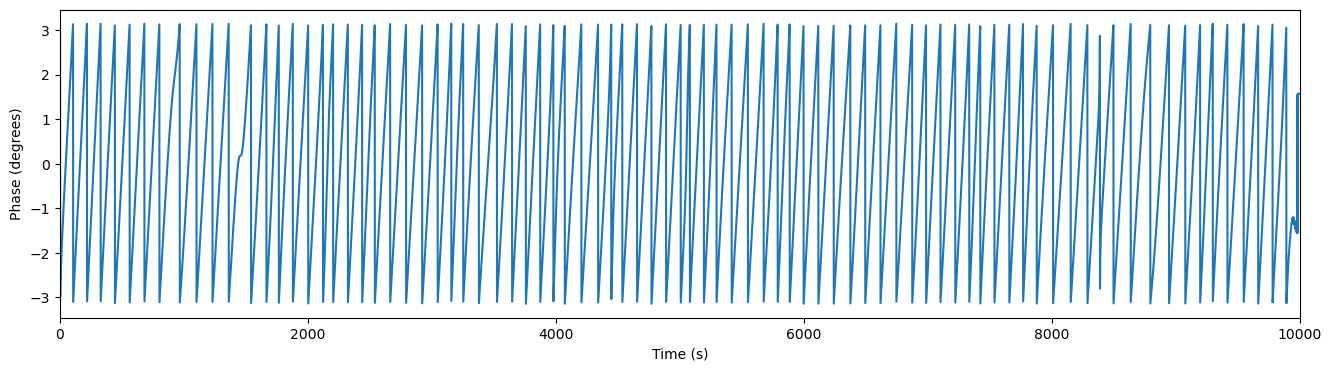

In [43]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_phase_radians"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

plt.xlim(0,10000)

(0.0, 10000.0)

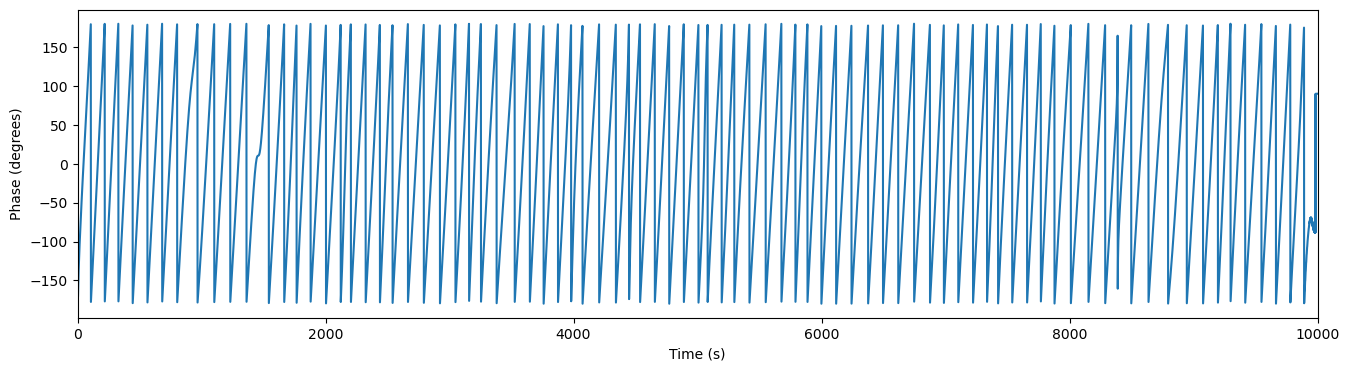

In [44]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["theta_BLA_trial_phase_degrees"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')

plt.xlim(0,10000)

In [45]:
BASIC_LFP_TRACES_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,theta_MD_baseline_phase_degrees,gamma_MD_baseline_filtered,gamma_MD_baseline_phase_radians,gamma_MD_baseline_phase_degrees,theta_MD_trial_filtered,theta_MD_trial_phase_radians,theta_MD_trial_phase_degrees,gamma_MD_trial_filtered,gamma_MD_trial_phase_radians,gamma_MD_trial_phase_degrees
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[124.4595429763872, 141.07390246461978, 142.23...","[0.04115775698493672, 0.11295380187572376, 0.1...","[-1.2855318441470045, -0.9143577729439708, -0....","[-73.65554909929288, -52.38884135467074, -32.6...","[-0.3194942774241363, -0.304396025623304, -0.2...","[2.6074996595573676, -3.0043265895311304, -2.9...","[149.39872557443616, -172.13523385906623, -168...","[-0.06335866385799732, -0.022468231799391763, ...","[-2.5419661952919865, -1.7454072291941767, -1....","[-145.64393465515843, -100.00446776444949, -75..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[142.6525041885258, 177.26427310038764, -179.7...","[-0.0903897354418438, -0.09704174941674733, -0...","[2.4911060919528394, 3.1039388936482557, -3.00...","[142.72986538822607, 177.84259847255115, -172....","[0.037630642935462255, 0.020604398694372195, 0...","[1.2914994813411182, 1.454539937086116, 1.5526...","[73.99746952418089, 83.33899952825874, 88.9628...","[0.0652597531108592, -0.04074664418442907, -0....","[0.9184400528995798, 1.7913540710530942, 2.362...","[52.62273876691798, 102.63702788492049, 135.36..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[131.08532941862214, 154.11387377060424, 155.3...","[-0.14491332090856698, -0.1314786579529695, -0...","[2.6342768860546695, -2.8140365484264476, -2.4...","[150.93294763979742, -161.23241762039694, -141...","[0.32434916974390937, 0.32233138764633296, 0.3...","[-0.7759614849836125, -0.2975671562717912, -0....","[-44.459318154265, -17.04934217608346, -15.063...","[0.04985940405473265, 0.09046372315808988, 0.1...","[-0.9770590376533174, -0.44320143405892515, -0...","[-55.981359192648874, -25.39357164572207, -1.0..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[-116.06831172743509, -102.42793212609777, -96...","[-0.29796191075925343, -0.21025925531419706, -...","[3.1024169743670087, -2.1927629506239206, -1.7...","[177.7553989209761, -125.63606254340398, -101....","[0.22803878841545244, 0.2296645716551549, 0.23...","[-0.9235665059870032, -0.5892114071348239, -0....","[-52.91646289269916, -33.75932686978985, -32.8...","[-0.1221915979466501, -0.2763996439260113, -0....","[2.0005709775727336, 2.455542238651779, 2.8586...","[114.62427363127891, 140.6922066908529, 163.78..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-58.75959768769791, -44.88577018927039, -43.5...","[-0.13981140887683305, -0.0859355465441699, -0...","[-3.0860632798902987, -2.085949282099884, -1.6...","[-176.81840124801423, -119.51609014266732, -95...",

- Combining all the LFP phases with the spike firing times

In [46]:
TRACE_AND_SPIKE_DF = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [47]:
TRACE_AND_SPIKE_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name',
       ...
       'n_spikes', 'sh', 'si_unit_id', 'recording_name', 'timestamp_isi',
       'current_isi', 'closest_trial', 'ephys_sample_from_trial_onset',
       'lfp_sample_from_trial_onset', 'cluster_id_with_file_name'],
      dtype='object', length=124)

- Getting the phase of all the spikes for each neuron

In [48]:
TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"]

0        -9986
1        -9966
2        -9948
3        -9928
4        -9906
          ... 
177850    9911
177851    9956
177852    9963
177853    9972
177854    9998
Name: lfp_sample_from_trial_onset, Length: 177855, dtype: int64

In [49]:
radian_phase_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trial_phase_radians" in col]

In [50]:
degree_phase_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trial_phase_degrees" in col]

In [51]:
degree_phase_columns

['theta_mPFC_trial_phase_degrees',
 'gamma_mPFC_trial_phase_degrees',
 'theta_vHPC_trial_phase_degrees',
 'gamma_vHPC_trial_phase_degrees',
 'theta_BLA_trial_phase_degrees',
 'gamma_BLA_trial_phase_degrees',
 'theta_LH_trial_phase_degrees',
 'gamma_LH_trial_phase_degrees',
 'theta_MD_trial_phase_degrees',
 'gamma_MD_trial_phase_degrees']

In [52]:
for col in radian_phase_columns:
    region_name = "_".join(col.split("_")[:3])
    print(region_name)
    TRACE_AND_SPIKE_DF["{}_spike_phase_radians".format(region_name)] = TRACE_AND_SPIKE_DF.apply(lambda x: x[col][x["lfp_sample_from_trial_onset"]], axis=1)

theta_mPFC_trial
gamma_mPFC_trial
theta_vHPC_trial
gamma_vHPC_trial
theta_BLA_trial
gamma_BLA_trial
theta_LH_trial
gamma_LH_trial
theta_MD_trial
gamma_MD_trial


In [53]:
for col in degree_phase_columns:
    region_name = "_".join(col.split("_")[:3])
    print(region_name)
    TRACE_AND_SPIKE_DF["{}_spike_phase_degrees".format(region_name)] = TRACE_AND_SPIKE_DF.apply(lambda x: x[col][x["lfp_sample_from_trial_onset"]], axis=1)

theta_mPFC_trial
gamma_mPFC_trial
theta_vHPC_trial
gamma_vHPC_trial
theta_BLA_trial
gamma_BLA_trial
theta_LH_trial
gamma_LH_trial
theta_MD_trial
gamma_MD_trial


In [54]:
TRACE_AND_SPIKE_DF.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,theta_mPFC_trial_spike_phase_degrees,gamma_mPFC_trial_spike_phase_degrees,theta_vHPC_trial_spike_phase_degrees,gamma_vHPC_trial_spike_phase_degrees,theta_BLA_trial_spike_phase_degrees,gamma_BLA_trial_spike_phase_degrees,theta_LH_trial_spike_phase_degrees,gamma_LH_trial_spike_phase_degrees,theta_MD_trial_spike_phase_degrees,gamma_MD_trial_spike_phase_degrees
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,106.946149,118.589811,37.460741,73.119936,-115.501694,-158.355143,-68.555418,94.913051,-93.921471,150.742485
1,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,170.133422,-176.596069,103.648648,48.728891,-44.164208,120.528596,-8.750558,148.960302,-29.219762,77.724176
2,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,-138.520404,-67.264628,156.522168,-142.842480,11.342335,39.823317,40.275934,41.584338,21.246263,115.455871
3,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,-81.429645,136.050760,-146.508929,-150.980004,71.383818,-16.815703,95.151648,-114.457133,76.341277,-72.356796
4,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,-16.510834,-57.550964,-83.695666,101.253018,138.510130,-76.816687,158.508588,-65.566342,138.519373,-46.004336


In [55]:
TRACE_AND_SPIKE_DF["recording_file"].unique()

array(['20221202_134600_omission_and_competition_subject_6_1_top_2_base_3_merged',
       '20221203_154800_omission_and_competition_subject_6_1_top_1_base_3_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged',
       '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged'],
      dtype=object)

In [56]:
radians_spike_columns = sorted([col for col in TRACE_AND_SPIKE_DF.columns if "trial_spike_phase_radians" in col])
degrees_spike_columns = sorted([col for col in TRACE_AND_SPIKE_DF.columns if "trial_spike_phase_degrees" in col])

In [57]:
radians_spike_columns

['gamma_BLA_trial_spike_phase_radians',
 'gamma_LH_trial_spike_phase_radians',
 'gamma_MD_trial_spike_phase_radians',
 'gamma_mPFC_trial_spike_phase_radians',
 'gamma_vHPC_trial_spike_phase_radians',
 'theta_BLA_trial_spike_phase_radians',
 'theta_LH_trial_spike_phase_radians',
 'theta_MD_trial_spike_phase_radians',
 'theta_mPFC_trial_spike_phase_radians',
 'theta_vHPC_trial_spike_phase_radians']

In [58]:
degrees_spike_columns

['gamma_BLA_trial_spike_phase_degrees',
 'gamma_LH_trial_spike_phase_degrees',
 'gamma_MD_trial_spike_phase_degrees',
 'gamma_mPFC_trial_spike_phase_degrees',
 'gamma_vHPC_trial_spike_phase_degrees',
 'theta_BLA_trial_spike_phase_degrees',
 'theta_LH_trial_spike_phase_degrees',
 'theta_MD_trial_spike_phase_degrees',
 'theta_mPFC_trial_spike_phase_degrees',
 'theta_vHPC_trial_spike_phase_degrees']

## Filtering for neurons that have enough spikes

- Getting rows that focus on the trial portion only

In [59]:
temp_df = TRACE_AND_SPIKE_DF[TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"] >= 1].copy()

In [60]:
TRACE_AND_SPIKE_DF.columns

Index(['time', 'recording_dir', 'recording_file', 'time_stamp_index',
       'video_file', 'video_frame', 'video_number', 'subject_info',
       'competition_closeness', 'video_name',
       ...
       'theta_mPFC_trial_spike_phase_degrees',
       'gamma_mPFC_trial_spike_phase_degrees',
       'theta_vHPC_trial_spike_phase_degrees',
       'gamma_vHPC_trial_spike_phase_degrees',
       'theta_BLA_trial_spike_phase_degrees',
       'gamma_BLA_trial_spike_phase_degrees',
       'theta_LH_trial_spike_phase_degrees',
       'gamma_LH_trial_spike_phase_degrees',
       'theta_MD_trial_spike_phase_degrees',
       'gamma_MD_trial_spike_phase_degrees'],
      dtype='object', length=144)

- Getting the total number of spikes for each neuron and each trial type

In [61]:
temp_df = temp_df.groupby(["trial_outcome", "cluster_id_with_file_name"]).count()["recording_dir"].reset_index()

In [62]:
temp_df[temp_df["recording_dir"] > 50].groupby(["trial_outcome"]).count()

,cluster_id_with_file_name,recording_dir
trial_outcome,,
lose,67,67
omission,33,33
rewarded,84,84
win,67,67


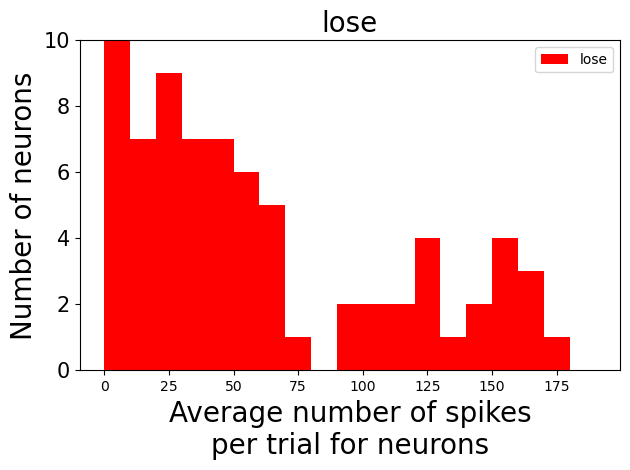

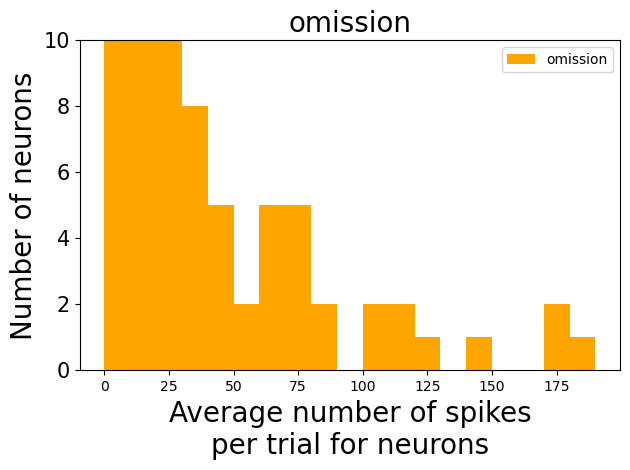

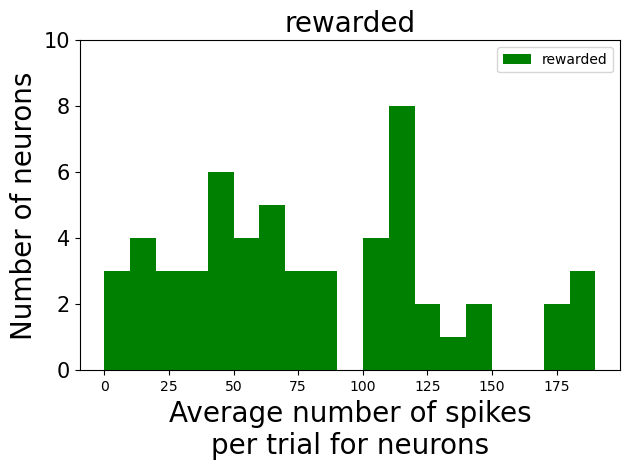

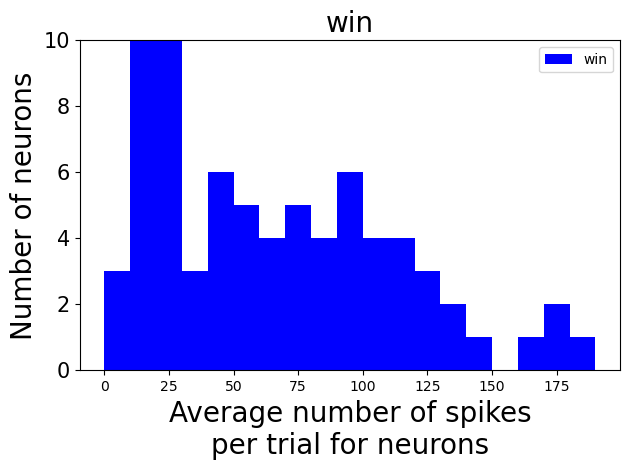

In [63]:
for outcome in temp_df["trial_outcome"].unique():
    fig, ax = plt.subplots()
    plt.hist(temp_df[temp_df["trial_outcome"] == outcome]["recording_dir"], color=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, bins=range(0, 200, 10))
    plt.legend()
    plt.ylim(0,10)
    # plt.xlim(0, 200)
    # plt.xticks(np.arange(0, 200, 10), rotation=90, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(outcome, fontsize=20)
    plt.xlabel("Average number of spikes\nper trial for neurons", fontsize=20)
    plt.ylabel("Number of neurons", fontsize=20)
    plt.tight_layout()
    plt.savefig("./proc/per_trial_spike_histogram_{}.png".format(outcome))
    
    plt.show()

In [64]:
len(temp_df["cluster_id_with_file_name"].unique())

126

In [65]:
temp_df = temp_df[temp_df["recording_dir"] >= 10].groupby("cluster_id_with_file_name").count()

In [66]:
high_spike_neurons = temp_df[temp_df["trial_outcome"] >= 4].reset_index()["cluster_id_with_file_name"]

In [67]:
high_spike_neurons

0     103_20230618_100636_standard_comp_to_omission_...
1     106_20230618_100636_standard_comp_to_omission_...
2     118_20230618_100636_standard_comp_to_omission_...
3     11_20230618_100636_standard_comp_to_omission_D...
4     123_20230618_100636_standard_comp_to_omission_...
                            ...                        
56    90_20230620_114347_standard_comp_to_omission_D...
57    93_20230618_100636_standard_comp_to_omission_D...
58    94_20230620_114347_standard_comp_to_omission_D...
59    99_20230618_100636_standard_comp_to_omission_D...
60    9_20230618_100636_standard_comp_to_omission_D2...
Name: cluster_id_with_file_name, Length: 61, dtype: object

## Getting the average number of spikes per trial

In [68]:
temp_df = TRACE_AND_SPIKE_DF[TRACE_AND_SPIKE_DF["lfp_sample_from_trial_onset"] >= 1].copy()

In [69]:
temp_df = temp_df.groupby(["trial_outcome", "cluster_id_with_file_name", "time"]).count().reset_index()

In [70]:
temp_df.groupby(["trial_outcome", "cluster_id_with_file_name"])["recording_dir"].mean()

trial_outcome  cluster_id_with_file_name                                                  
lose           103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged    130.000000
               105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged     16.750000
               106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged      5.333333
               118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged      4.333333
               11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged      16.000000
                                                                                                 ...    
win            93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged      3.250000
               94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged      7.857143
               98_20230618_100636_standard_comp_to_omission_D2_subj_1

In [71]:
for col in TRACE_AND_SPIKE_DF.columns:
    print(col)

time
recording_dir
recording_file
time_stamp_index
video_file
video_frame
video_number
subject_info
competition_closeness
video_name
all_subjects
current_subject
trial_outcome
lfp_index
baseline_lfp_timestamp_range
trial_lfp_timestamp_range
baseline_ephys_timestamp_range
trial_ephys_timestamp_range
baseline_videoframe_range
trial_videoframe_range
trial_number
Cohort
spike_interface_mPFC
spike_interface_vHPC
spike_interface_BLA
spike_interface_LH
spike_interface_MD
mPFC_baseline_lfp_trace
mPFC_trial_lfp_trace
vHPC_baseline_lfp_trace
vHPC_trial_lfp_trace
BLA_baseline_lfp_trace
BLA_trial_lfp_trace
LH_baseline_lfp_trace
LH_trial_lfp_trace
MD_baseline_lfp_trace
MD_trial_lfp_trace
lfp_trial_all_lfp_index
lfp_baseline_all_lfp_index
lfp_trial_all_ephys_index
lfp_baseline_all_ephys_index
theta_mPFC_baseline_filtered
theta_mPFC_baseline_phase_radians
theta_mPFC_baseline_phase_degrees
gamma_mPFC_baseline_filtered
gamma_mPFC_baseline_phase_radians
gamma_mPFC_baseline_phase_degrees
theta_mPFC_trial

In [72]:
high_spike_neurons

0     103_20230618_100636_standard_comp_to_omission_...
1     106_20230618_100636_standard_comp_to_omission_...
2     118_20230618_100636_standard_comp_to_omission_...
3     11_20230618_100636_standard_comp_to_omission_D...
4     123_20230618_100636_standard_comp_to_omission_...
                            ...                        
56    90_20230620_114347_standard_comp_to_omission_D...
57    93_20230618_100636_standard_comp_to_omission_D...
58    94_20230620_114347_standard_comp_to_omission_D...
59    99_20230618_100636_standard_comp_to_omission_D...
60    9_20230618_100636_standard_comp_to_omission_D2...
Name: cluster_id_with_file_name, Length: 61, dtype: object

In [73]:
BACK_UP_TRACE_AND_SPIKE_DF = TRACE_AND_SPIKE_DF.copy()

In [74]:
# TRACE_AND_SPIKE_DF = TRACE_AND_SPIKE_DF[TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].isin(high_spike_neurons)].copy()

In [75]:
spike_lfp_coupling_df = pd.read_csv("../2023_09_26_omission_lfp_analysis/proc/lfp_spike_coupling/lfp_spike_coupling.csv")

In [76]:
spike_lfp_coupling_df

,Unnamed: 0,cluster_id_with_file_name,outcome,ppc,rayleightest,band,region,subj_id,date,significant
0,0,17_20221202_134600_omission_and_competition_su...,rewarded,-0.001322,0.971729,gamma,BLA,6.1,20221202,False
1,1,17_20221202_134600_omission_and_competition_su...,omission,0.000803,0.306091,gamma,BLA,6.1,20221202,False
2,2,17_20221202_134600_omission_and_competition_su...,win,NaN,NaN,gamma,BLA,6.1,20221202,False
3,3,17_20221202_134600_omission_and_competition_su...,lose,NaN,NaN,gamma,BLA,6.1,20221202,False
4,4,21_20221202_134600_omission_and_competition_su...,rewarded,-0.000076,0.465368,gamma,BLA,6.1,20221202,False
...,...,...,...,...,...,...,...,...,...,...
5035,5035,50_20230620_114347_standard_comp_to_omission_D...,lose,-0.005537,0.755607,theta,vHPC,1.2,20230620,False
5036,5036,254_20230620_114347_standard_comp_to_omission_...,rewarded,-0.001986,0.474347,theta,vHPC,1.2,20230620,False
5037,5037,254_20230620_114347_standard_comp_to_omission_...,omission,-0.001386,0.395920,theta,vHPC,1.2,20230620,False
5038,5038,254_20230620_114347_standard_comp_to_omission_...,win,0.003276,0.225073,theta,vHPC,1.2,20230620,False


In [77]:
spike_lfp_coupling_df["significant"] = spike_lfp_coupling_df["rayleightest"] <= 0.05

In [78]:
spike_lfp_coupling_df.groupby(["region", "band", "significant", "outcome"]).count()

Unnamed: 0  cluster_id_with_file_name  ppc  \
region band  significant outcome                                                
BLA    gamma False       lose             121                        121  104   
                         omission         124                        124   87   
                         rewarded         119                        119   97   
                         win              118                        118   95   
             True        lose               5                          5    5   
...                                       ...                        ...  ...   
vHPC   theta False       win              120                        120   97   
             True        lose               7                          7    7   
                         omission           8                          8    8   
                         rewarded           9                          9    9   
                         win                6                          6    6   

                                   rayleightest  subj_id  date  
region band  significant outcome                                
BLA    gamma False       lose               104      121   121  
                         omission            88      124   124  
                         rewarded            97      119   119  
                         win                 96      118   118  
             True        lose                 5        5     5  
...                                         ...      ...   ...  
vHPC   theta False       win                 98      120   120  
             True        lose                 7        7     7  
                         omission             8        8     8  
                         rewarded             9        9     9  
                         win                  6        6     6  

[80 rows x 6 columns]

In [79]:
spike_lfp_coupling_df

,Unnamed: 0,cluster_id_with_file_name,outcome,ppc,rayleightest,band,region,subj_id,date,significant
0,0,17_20221202_134600_omission_and_competition_su...,rewarded,-0.001322,0.971729,gamma,BLA,6.1,20221202,False
1,1,17_20221202_134600_omission_and_competition_su...,omission,0.000803,0.306091,gamma,BLA,6.1,20221202,False
2,2,17_20221202_134600_omission_and_competition_su...,win,NaN,NaN,gamma,BLA,6.1,20221202,False
3,3,17_20221202_134600_omission_and_competition_su...,lose,NaN,NaN,gamma,BLA,6.1,20221202,False
4,4,21_20221202_134600_omission_and_competition_su...,rewarded,-0.000076,0.465368,gamma,BLA,6.1,20221202,False
...,...,...,...,...,...,...,...,...,...,...
5035,5035,50_20230620_114347_standard_comp_to_omission_D...,lose,-0.005537,0.755607,theta,vHPC,1.2,20230620,False
5036,5036,254_20230620_114347_standard_comp_to_omission_...,rewarded,-0.001986,0.474347,theta,vHPC,1.2,20230620,False
5037,5037,254_20230620_114347_standard_comp_to_omission_...,omission,-0.001386,0.395920,theta,vHPC,1.2,20230620,False
5038,5038,254_20230620_114347_standard_comp_to_omission_...,win,0.003276,0.225073,theta,vHPC,1.2,20230620,False


In [80]:
spike_lfp_coupling_df.to_csv("./proc/lfp_spike_coupling/lfp_spike_coupling.csv")

In [81]:
from itertools import product

In [82]:
spike_lfp_coupling_df["band"].unique()

array(['gamma', 'theta'], dtype=object)

In [83]:
for band, region in list(product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique())):
    current_df = spike_lfp_coupling_df[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
    current_df = current_df[["cluster_id_with_file_name", "outcome", "significant"]]
    current_df = current_df.pivot_table('significant', ['cluster_id_with_file_name'], 'outcome')
    current_df["significance_total"] = current_df["lose"] + current_df["omission"] + current_df["rewarded"] + current_df["win"]

    

In [84]:
# current_df

current_df

outcome,lose,omission,rewarded,win,significance_total
cluster_id_with_file_name,,,,,
103_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged,0.0,0.0,0.0,0.0,0.0
105_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged,0.0,0.0,0.0,0.0,0.0
106_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged,0.0,0.0,0.0,0.0,0.0
118_20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged,0.0,0.0,0.0,1.0,1.0
11_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
93_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged,0.0,0.0,0.0,0.0,0.0
94_20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged,0.0,0.0,0.0,0.0,0.0
98_20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged,0.0,0.0,0.0,0.0,0.0


In [85]:
example_df = spike_lfp_coupling_df[(spike_lfp_coupling_df["region"] == "BLA")]

In [86]:
example_df

,Unnamed: 0,cluster_id_with_file_name,outcome,ppc,rayleightest,band,region,subj_id,date,significant
0,0,17_20221202_134600_omission_and_competition_su...,rewarded,-0.001322,0.971729,gamma,BLA,6.1,20221202,False
1,1,17_20221202_134600_omission_and_competition_su...,omission,0.000803,0.306091,gamma,BLA,6.1,20221202,False
2,2,17_20221202_134600_omission_and_competition_su...,win,NaN,NaN,gamma,BLA,6.1,20221202,False
3,3,17_20221202_134600_omission_and_competition_su...,lose,NaN,NaN,gamma,BLA,6.1,20221202,False
4,4,21_20221202_134600_omission_and_competition_su...,rewarded,-0.000076,0.465368,gamma,BLA,6.1,20221202,False
...,...,...,...,...,...,...,...,...,...,...
3019,3019,50_20230620_114347_standard_comp_to_omission_D...,lose,-0.005891,0.791260,theta,BLA,1.2,20230620,False
3020,3020,254_20230620_114347_standard_comp_to_omission_...,rewarded,-0.007267,0.932545,theta,BLA,1.2,20230620,False
3021,3021,254_20230620_114347_standard_comp_to_omission_...,omission,-0.007767,0.555251,theta,BLA,1.2,20230620,False
3022,3022,254_20230620_114347_standard_comp_to_omission_...,win,-0.005804,0.878633,theta,BLA,1.2,20230620,False


In [87]:
from collections import Counter
import collections

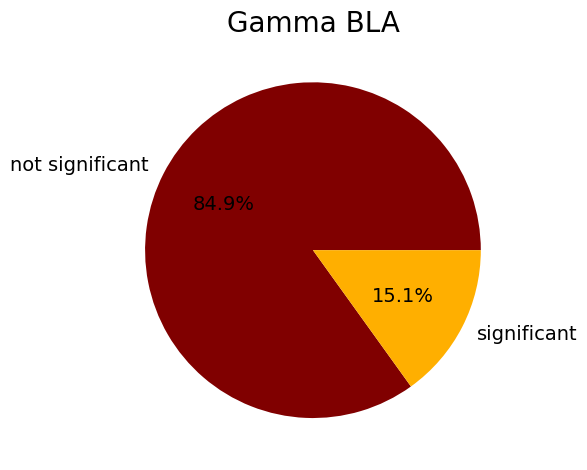

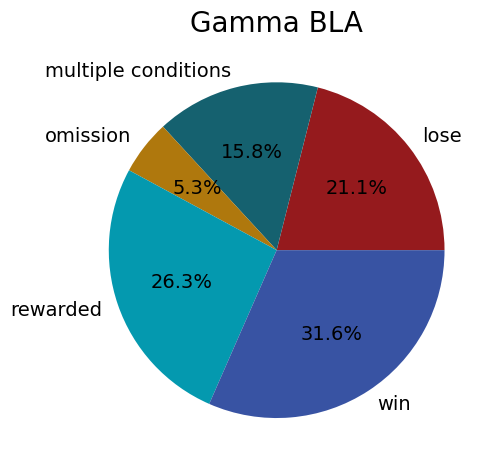

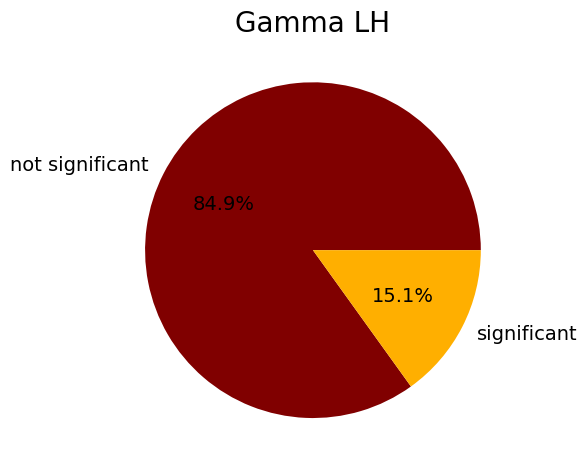

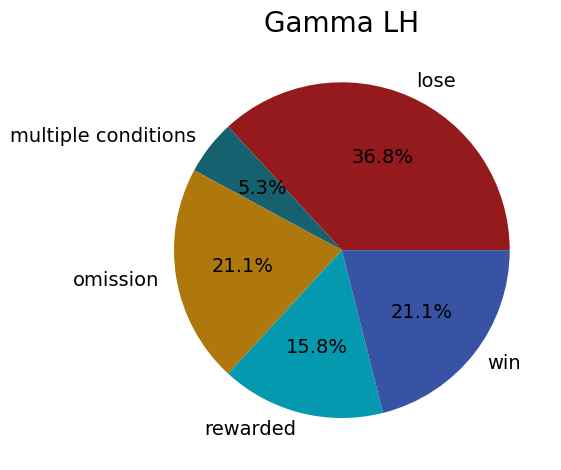

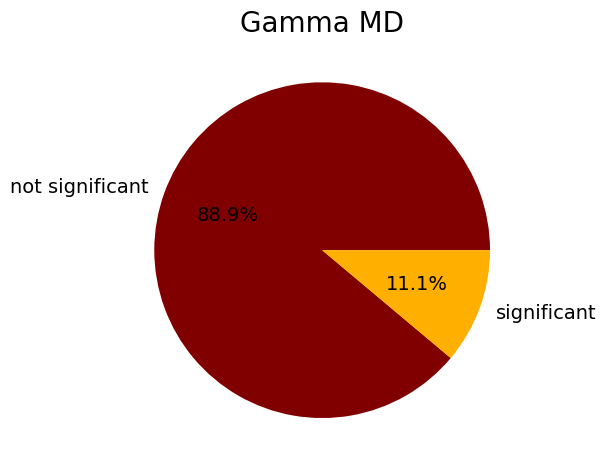

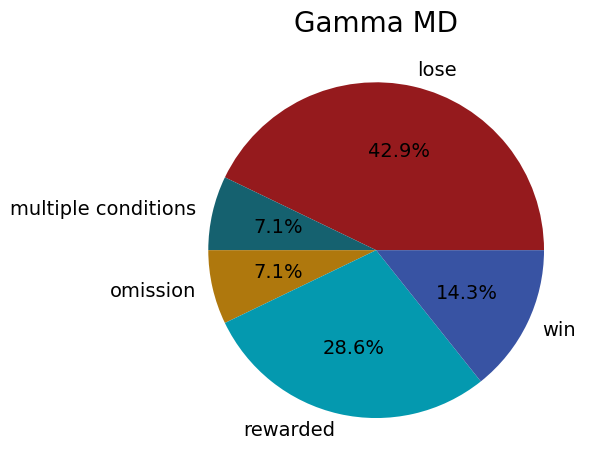

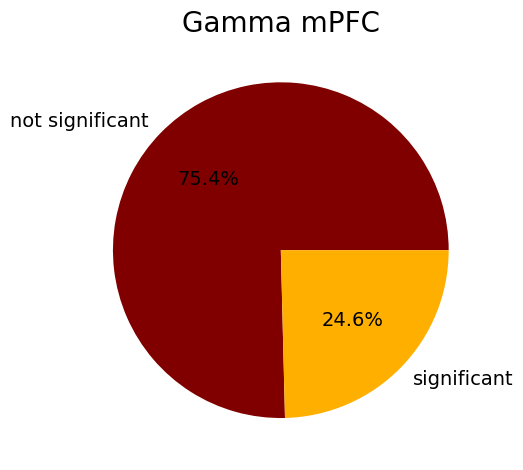

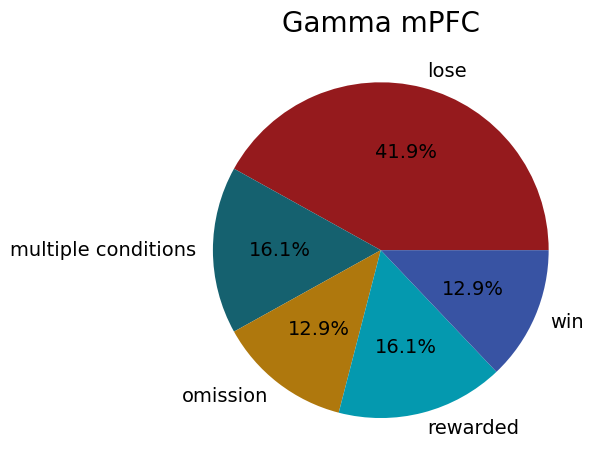

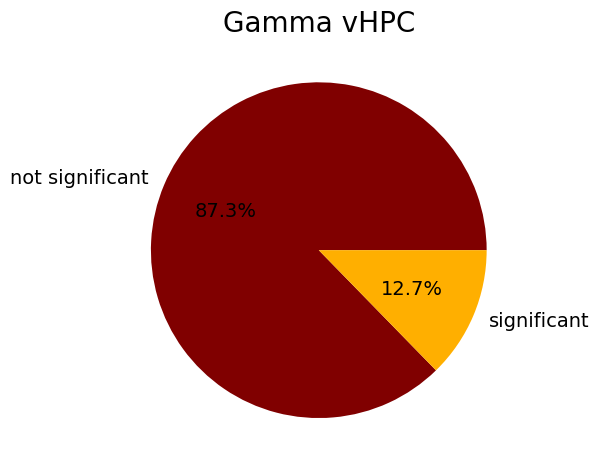

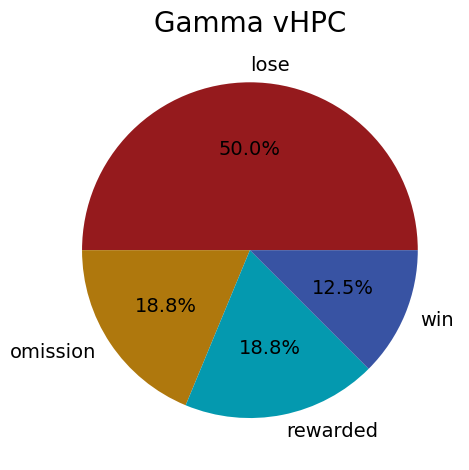

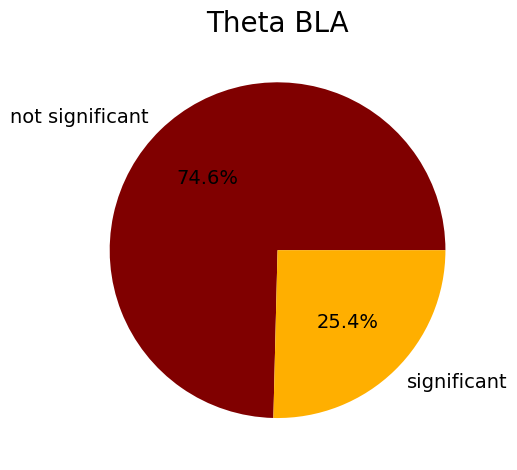

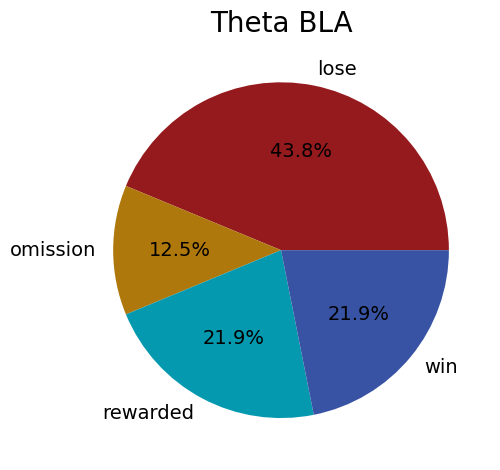

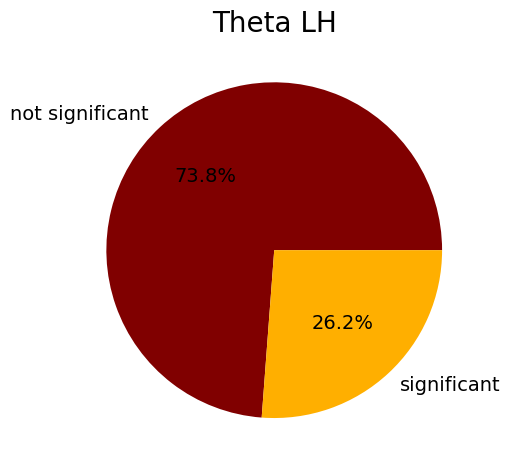

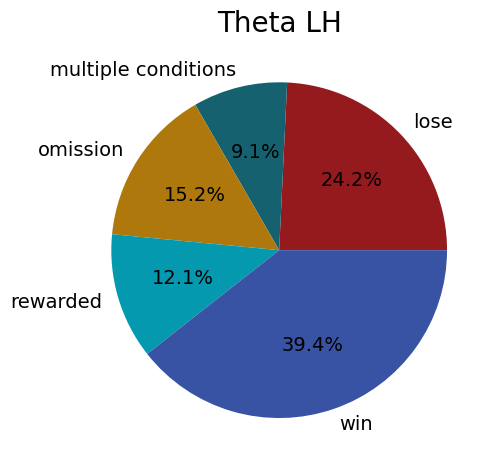

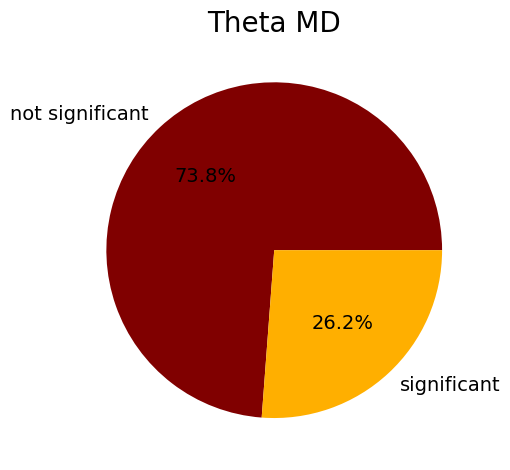

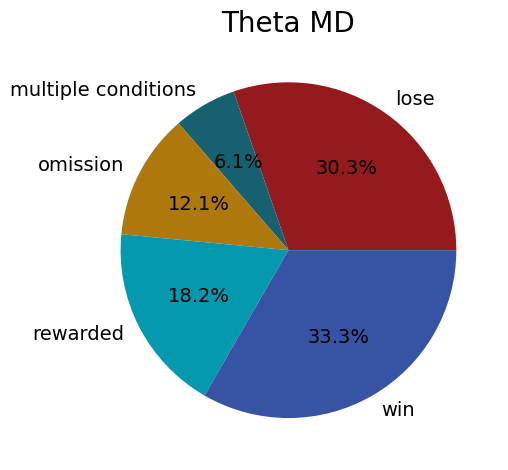

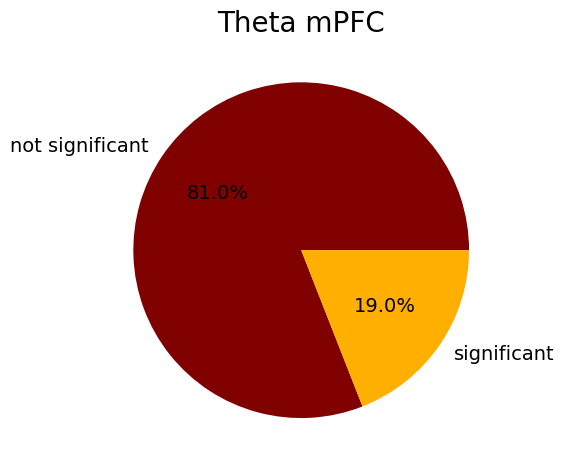

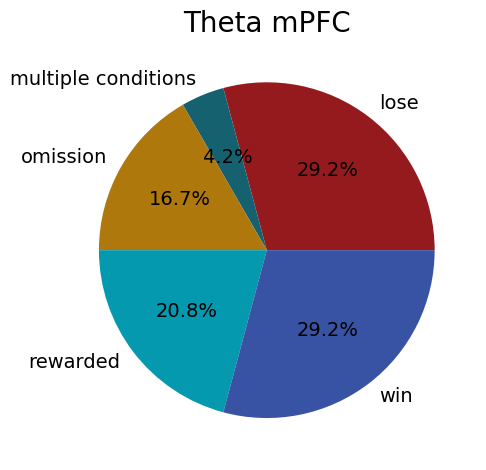

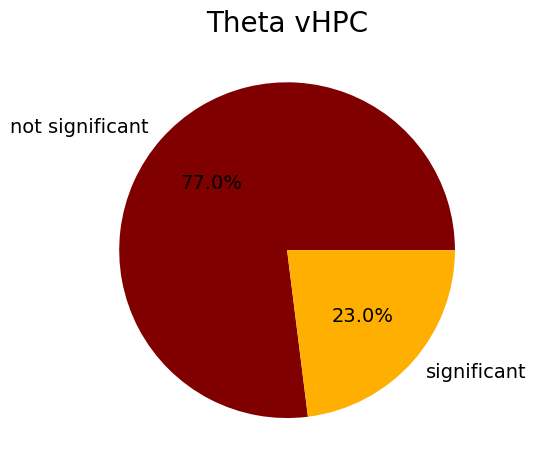

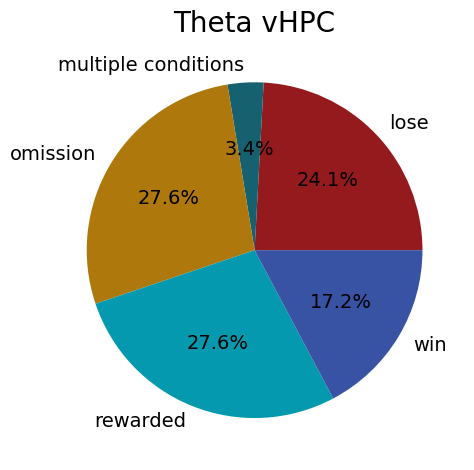

In [89]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # plt.figure(figsize=(24,6))
    fig, ax = plt.subplots()
    plt.title("{} {}".format(band.capitalize(), region), fontsize=20)
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
    
    significant_band_and_region_df = band_and_region_df[(spike_lfp_coupling_df["rayleightest"] <= 0.05)]

    # Group by neuron_id and get sets of outcomes for each neuron
    grouped = significant_band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)

    for index, value in grouped.items():
        if len(value) >= 2:
            grouped[index] = frozenset({"multiple conditions"})
    significant_labels = ["not significant", "significant"]
    plt.pie([len(band_and_region_df["cluster_id_with_file_name"].unique()) - len(grouped), len(grouped)], labels=significant_labels, autopct='%1.1f%%', textprops={'fontsize': 14}, colors=[OUTCOME_TO_COLOR[label] for label in significant_labels])
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_significant.eps".format(band, region))

    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("{} {}".format(band.capitalize(), region), fontsize=20)

    # Count how many neurons are associated with each unique combination of trial outcomes
    outcome_combinations = Counter(grouped)
    
    outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
    # outcome_combinations["not_significant"] = len(band_and_region_df["cluster_id_with_file_name"].unique()) - len(grouped)
    
    outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
    plt.pie(outcome_combinations.values(), labels=outcome_combinations.keys(), autopct='%1.1f%%', textprops={'fontsize': 14}, colors=[OUTCOME_TO_COLOR[label] for label in outcome_combinations.keys()])
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_all_labels.png".format(band, region))
    plt.savefig("./proc/lfp_spike_coupling/phase_locked_{}_{}_all_labels.eps".format(band, region))

    plt.show()

In [ ]:
len(band_and_region_df["cluster_id_with_file_name"].unique())

In [ ]:
outcome_combinations

In [ ]:
band_and_region_df.groupby("outcome")["rayleightest"].mean().index

In [ ]:
band_and_region_df.groupby("outcome")["rayleightest"].sem()

In [ ]:
band_and_region_df.groupby("outcome")["rayleightest"].mean().index.map(BASELINE_OUTCOME_TO_COLOR)

In [ ]:
spike_lfp_coupling_df

In [ ]:
band_and_region_df

In [ ]:
from itertools import chain, combinations
from collections import Counter


In [ ]:
# Function to get all subsets of a set
def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(1, len(ss) + 1)))

In [ ]:
# Get unique trial outcomes
unique_outcomes = spike_lfp_coupling_df['outcome'].unique()

In [ ]:
neuron_counts = {}
for subset in all_subsets(unique_outcomes):
    subset_key = '&'.join(subset)
    filtered_df = band_and_region_df[band_and_region_df['outcome'].isin(subset)]
    unique_neurons = filtered_df['cluster_id_with_file_name'].unique()
    neuron_counts[subset_key] = len(unique_neurons)

In [ ]:
import collections

In [ ]:
# Group by neuron_id and get sets of outcomes for each neuron
grouped = band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)

# Count how many neurons are associated with each unique combination of trial outcomes
outcome_combinations = Counter(grouped)

outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}

outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))

In [ ]:
def combine_hex_values(d):
  d_items = sorted(d.items())
  tot_weight = sum(d.values())
  red = int(sum([int(k[:2], 16)*v for k, v in d_items])/tot_weight)
  green = int(sum([int(k[2:4], 16)*v for k, v in d_items])/tot_weight)
  blue = int(sum([int(k[4:6], 16)*v for k, v in d_items])/tot_weight)
  zpad = lambda x: x if len(x)==2 else '0' + x
  return zpad(hex(red)[2:]) + zpad(hex(green)[2:]) + zpad(hex(blue)[2:])

In [ ]:
combine_hex_values({"ffffff": 1.0, "0000ff": 0.5, "000000": 0.05})
# 'a4a4f6'
# >>> combine_hex_values({"ffffff": 1.0, "0000ff": 0.5, "000000": 0.5})
# '7f7fbf'
# >>> combine_hex_values({"ffffff": 0.05, "0000ff": 1.0, "000000": 0.05})
# '0b0bf3'

In [ ]:
matplotlib.colors.to_hex("orange", keep_alpha=False)

In [ ]:
[{color[1:]: 1.0 for color in [matplotlib.colors.to_hex(BASELINE_OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]} for key in outcome_combinations.keys()]

In [ ]:
[combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(BASELINE_OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()]

In [ ]:
spike_lfp_coupling_df[spike_lfp_coupling_df["ppc"] >= 0.1]

In [ ]:
band_and_region_df.groupby("outcome")["rayleightest"]

In [ ]:
len(spike_lfp_coupling_df["cluster_id_with_file_name"].unique())


In [ ]:
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
    
    plt.title("{} {}".format(band, region), fontsize=20)
    plt.xlabel("Rayleigh p-value")
    plt.hist(band_and_region_df["rayleightest"])
    # plt.ylabel()
    plt.show()
    
    fig, ax = plt.subplots()

In [ ]:
grouped.index

In [ ]:
for index, group in zip(grouped.index, grouped):
    print()

In [ ]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # plt.figure(figsize=(24,6))
    fig, ax = plt.subplots()

    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    # Group by neuron_id and get sets of outcomes for each neuron
    grouped = band_and_region_df.groupby('outcome')['rayleightest'].apply(list)
    for outcome in grouped
    break
    # Count how many neurons are associated with each unique combination of trial outcomes
    outcome_combinations = Counter(grouped)
    
    outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
    
    outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
    
    plt.bar([key.replace("_", "\n") for key in outcome_combinations.keys()], outcome_combinations.values(), color=["#" + combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(BASELINE_OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()])
    plt.xticks(rotation=22.5, fontsize=10)
    plt.title("{} {}".format(band, region), fontsize=20)
    plt.ylim(0, 15)
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/bar/{}_{}_lfp_spike_coupling_bar.png".format(band, region))
    plt.show()

In [ ]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # plt.figure(figsize=(24,6))
    fig, ax = plt.subplots()

    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    band_and_region_df = band_and_region_df[(spike_lfp_coupling_df["rayleightest"] <= 0.05) & (spike_lfp_coupling_df["ppc"]>= 0.001)]

    # Group by neuron_id and get sets of outcomes for each neuron
    grouped = band_and_region_df.sort_values("outcome").groupby('cluster_id_with_file_name')['outcome'].apply(frozenset)
    
    # Count how many neurons are associated with each unique combination of trial outcomes
    outcome_combinations = Counter(grouped)
    
    outcome_combinations = {"_".join(sorted(k)): v for k, v in outcome_combinations.items()}
    
    outcome_combinations = collections.OrderedDict(sorted(outcome_combinations.items()))
    
    plt.bar([key.replace("_", "\n") for key in outcome_combinations.keys()], outcome_combinations.values(), color=["#" + combine_hex_values({color[1:]: 1.0 for color in [matplotlib.colors.to_hex(BASELINE_OUTCOME_TO_COLOR[k], keep_alpha=False) for k in key.split("_")]}) for key in outcome_combinations.keys()])
    plt.xticks(rotation=22.5, fontsize=15)
    plt.ylabel("Number of neurons", fontsize=15)
    plt.title("Phase-locked neurons in {} {}".format(band, region), fontsize=20)
    plt.ylim(0, 15)
    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/bar/{}_{}_lfp_spike_coupling_bar.png".format(band, region))
    plt.show()

In [ ]:
all_outcomes = (band_and_region_df["outcome"].unique())

In [ ]:
raise ValueError()

In [ ]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    # fig, ax = plt.subplots()
    # plt.figure(figsize=(12,12))
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region)]
       
    band_and_region_df = band_and_region_df[(spike_lfp_coupling_df["rayleightest"] <= 0.05) & (spike_lfp_coupling_df["ppc"]>= 0.001)]
    
    outcome_to_neurons = {}
    for outcome in sorted(band_and_region_df["outcome"].unique()):
        outcome_to_neurons[outcome] = set(band_and_region_df[band_and_region_df["outcome"] == outcome]["cluster_id_with_file_name"].values)
    # keys, value = zip(*outcome_to_neurons.items())
    # venn3(list(value), keys)

    venn(outcome_to_neurons, cmap=[BASELINE_OUTCOME_TO_COLOR[outcome] for outcome in sorted(band_and_region_df["outcome"].unique())], fontsize=20, figsize=(8,8))
    plt.title("{} {}".format(band, region), fontsize=20)

    plt.tight_layout()
    plt.savefig("./proc/lfp_spike_coupling/venn/{}_{}_lfp_spike_coupling_venn.png".format(band, region))
    plt.show()


In [ ]:
keys, value = zip(*outcome_to_neurons.items())

In [ ]:
keys

In [ ]:
outcome_to_neurons.values()

In [ ]:
for band, region in product(spike_lfp_coupling_df["band"].unique(), spike_lfp_coupling_df["region"].unique()):
    fig, ax = plt.subplots()
    plt.title("{} {}".format(band, region))
    band_and_region_df = spike_lfp_coupling_df.dropna(subset="rayleightest")[(spike_lfp_coupling_df["band"] == band) & (spike_lfp_coupling_df["region"] == region) & (spike_lfp_coupling_df["rayleightest"] <= 0.1)]
    
    
    
    plt.bar(x=band_and_region_df.groupby("outcome")["rayleightest"].count().index, height=band_and_region_df.groupby("outcome")["rayleightest"].count(), color=band_and_region_df.groupby("outcome")["rayleightest"].count().index.map(BASELINE_OUTCOME_TO_COLOR))
    plt.ylim(0,25)
    plt.show()
    # region_df.groupby("")

In [ ]:
raise ValueError()

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
id_and_outcome_to_stats.keys()

In [ ]:
all_phase_df = []
for key, value in id_and_outcome_to_stats.items():
    current_df = pd.DataFrame.from_dict(id_and_outcome_to_stats[key])
    current_df["region"] = key
    all_phase_df.append(current_df)

In [ ]:
all_phase_df = pd.concat(all_phase_df)

In [ ]:
raise ValueError()

In [ ]:
from astropy import units as u
data = np.array([130, 90, 0, 145])*u.deg

In [ ]:
# Creating a dictionary that we can add all dataframes to
id_and_outcome_to_stats = defaultdict(list)

# iterating through each band and each brain region
for radian_col, degree_col in zip(radians_spike_columns, degrees_spike_columns):
    # Iterating through each neuron
    for index, neuron_id in enumerate(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()):        
        print(col)
        print(neuron_id)
        # # Instantiating a new plot
        # fig, ax = plt.subplots()
        #Plotting the histogram
        figure, axis = plt.subplots(2, 2) 
        ax = plt.subplot(1,1,1, polar=True)
        plt.title(neuron_id)
        plt.xlabel(col)
        # Iterating through each trial outcome
        for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():
            print(outcome)
            # Getting all the rows that have this trial outcome and this neuron
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            # Getting the phases of the current brain regions for all the spikes 
            radian_spike_phases = outcome_df[radian_col]
            binned_phases = np.digitize(radian_spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            

            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            
            # Calculating the ppc values
            ppc_val = PPC(radian_spike_phases)
            # Calculating the Rayleightest            
            rayleigh_val = rayleightest(outcome_df[degree_col]) 
            print("\tSpike phase histogram: {}".format(spike_phase_hist))
            print("\tppc_val: {}".format(ppc_val))
            print("\trayleigh_val: {}".format(rayleigh_val))


            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleigh_val})

        plt.legend()
        # plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        break
    break

In [ ]:
raise ValueError()
# Creating a dictionary that we can add all dataframes to
id_and_outcome_to_stats = defaultdict(list)

# Iterating through each brain region
for col in spike_columns:
    # Iterating through each neuron
    for index, neuron_id in enumerate(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique()):        
        print(col)
        print(neuron_id)
        # # Instantiating a new plot
        # fig, ax = plt.subplots()
        #Plotting the histogram
        ax = plt.subplot(1,1,1, polar=True)
        plt.title(neuron_id)
        plt.xlabel(col)
        # Iterating through each trial outcome
        for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():
            print(outcome)
            # Getting all the rows that have this trial outcome and this neuron
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            # Getting the phases of the current brain regions for all the spikes 
            spike_phases = outcome_df[col]
            binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            

            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            
            # Calculating the ppc values
            ppc_val = PPC(spike_phases)
            # Calculating the Rayleightest            
            rayleigh_val = rayleightest(spike_phases) 
            print("\tSpike phase histogram: {}".format(spike_phase_hist))
            print("\tppc_val: {}".format(ppc_val))
            print("\trayleigh_val: {}".format(rayleigh_val))


            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleigh_val})

        plt.legend()
        plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        
    

In [ ]:
pd.DataFrame.from_dict(id_and_outcome_to_stats)

In [ ]:
id_and_outcome_to_stats.keys()

In [ ]:
all_phase_df = []
for key, value in id_and_outcome_to_stats.items():
    current_df = pd.DataFrame.from_dict(id_and_outcome_to_stats[key])
    current_df["region"] = key
    all_phase_df.append(current_df)

In [ ]:
all_phase_df = pd.concat(all_phase_df)

In [ ]:
all_phase_df.sort_values("rayleightest").head(n=20)


id_and_outcome_to_stats = defaultdict(list)
for col in spike_columns:

    for id in range(len(TRACE_AND_SPIKE_DF["cluster_id_with_file_name"].unique())):
        fig, ax = plt.subplots()
        
        for outcome in TRACE_AND_SPIKE_DF["trial_outcome"].unique():
        
            outcome_df = TRACE_AND_SPIKE_DF[(TRACE_AND_SPIKE_DF["trial_outcome"] == outcome) & (TRACE_AND_SPIKE_DF["cluster_id_with_file_name"] == neuron_id)]
            
            spike_phases = outcome_df[col]
        
            N_BINS = 18
            PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
            binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
            spike_phase_hist = np.zeros(N_BINS+1)
            for bin in range(0, N_BINS + 1):
                spike_phase_hist[bin] = np.sum(binned_phases == bin)
            print(spike_phase_hist)
            
            #Plot
            ax = plt.subplot(1,1,1, polar=True)
            # plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color=BASELINE_OUTCOME_TO_COLOR[outcome], alpha=0.5)
            plt.bar(PHASE_BINS, pre.MinMaxScaler().fit_transform(spike_phase_hist.reshape(-1,1)).T[0], width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0, edgecolor=BASELINE_OUTCOME_TO_COLOR[outcome], label=outcome, color='none', linewidth = 5)
            ppc_val = PPC(spike_phases)



            
            rayleightest(data) 
            
            id_and_outcome_to_stats[col].append({"cluster_id_with_file_name": neuron_id, "outcome": outcome, "ppc": ppc_val, "rayleightest": rayleightest(spike_phases)})
            plt.title(neuron_id)
            plt.xlabel(col)
        plt.legend()
        plt.savefig("./proc/lfp_spike_coupling/{}_{}.png".format(neuron_id, col.split("_")[0]))
        plt.show()
        break
    break

In [ ]:
ppc_df = pd.DataFrame(id_and_outcome_to_stats).dropna()

In [ ]:
ppc_df

In [ ]:
    sns.violinplot(x=ppc_df['outcome'], y=ppc_df['ppc'], palette=BASELINE_OUTCOME_TO_COLOR)

In [ ]:
fig, ax = plt.subplots()

# Create a separate violin plot for each group
for i, group in enumerate(ppc_df["outcome"].unique()):
    group_data = ppc_df[ppc_df['outcome'] == group]  # filter the data for this group
    sns.violinplot(x=group_data['outcome'], y=group_data['ppc'])
    # axs[i].set_title(f'Violin plot for {group}')

plt.tight_layout()
plt.show()

In [ ]:
# Create a histogram with Seaborn's 'histplot'
plt.figure(figsize=(10, 6))
sns.histplot(data=ppc_df, x='ppc', hue='outcome', multiple="stack", binwidth=0.01)

# Set labels and title
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Different Groups')

# Show plot
plt.show()

In [ ]:
spike_phases = TRACE_AND_SPIKE_DF["mPFC_trial_spike_phase"]

In [ ]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
spike_phase_hist = np.zeros(N_BINS+1)
for bin in range(0, N_BINS + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(PHASE_BINS, spike_phase_hist, width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0)

# OLD MERGING CODE

In [ ]:
raise ValueError()

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"] = BASIC_LFP_TRACES_DF.apply(lambda x: MERGED_SPIKE_TRIAL_DF[(MERGED_SPIKE_TRIAL_DF["recording_name"] == x["recording_file"]) & (MERGED_SPIKE_TRIAL_DF["closest_trial"] == x["time_stamp_index"])], axis=1)

In [ ]:
BASIC_LFP_TRACES_DF["has_spike_df"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: not x.empty)

In [ ]:
BASIC_LFP_TRACES_DF = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["has_spike_df"]].reset_index(drop=True)

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: {k: sorted(list(v)) for k, v in x.groupby("cluster_id")["lfp_sample_from_trial_onset"]})

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"] = BASIC_LFP_TRACES_DF["spike_df"].apply(lambda x: x.groupby("cluster_id")["lfp_sample_from_trial_onset"].apply(list).reset_index(name='lfp_sample_from_trial_onset'))

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

# Filtering and getting the phase of all the LFPs

- Filtering all the data

In [ ]:
BASIC_LFP_TRACES_DF.head()

In [ ]:
trace_columns = [col for col in BASIC_LFP_TRACES_DF.columns if "trace" in col]

In [ ]:
FREQ_BAND = [4, 12]


In [ ]:
for col in trace_columns:
    region_name = "_".join(col.split("_")[:2])
    BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)] = BASIC_LFP_TRACES_DF[col].apply(lambda x: filtfilt(numerator_b, denominator_a, x, padtype=None))

    BASIC_LFP_TRACES_DF["{}_phase".format(region_name)] = BASIC_LFP_TRACES_DF["{}_filtered".format(region_name)].apply(lambda x: np.angle(hilbert(x), deg=False))
    


- Plotting an example filtered trace

In [ ]:
MERGED_SPIKE_TRIAL_DF.head()

In [ ]:

plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_filtered"].iloc[0])

current_spike_df = BASIC_LFP_TRACES_DF["spike_df"].iloc[0]
current_unit_spikes = current_spike_df[current_spike_df["cluster_id"] == current_spike_df["cluster_id"].unique()[0]]["lfp_sample_from_trial_onset"].values

for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(BASIC_LFP_TRACES_DF["BLA_trial_phase"].iloc[0])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
# plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)
for spike in current_unit_spikes:
    plt.axvline(spike, color='black', alpha=.5)
plt.xlim(0,10000)

In [ ]:
BASIC_LFP_TRACES_DF.head()

In [ ]:
BASIC_LFP_TRACES_DF["neuron_to_spike_times"].iloc[0]

In [ ]:
spike_phases = []
for spike_time in spike_times:
    spike_phases.append(phase[int(round(spike_time*fs))])

# Plotting phase and LFP

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[0]

In [ ]:
BASIC_LFP_TRACES_DF["spike_df"].iloc[5].columns

In [ ]:
BASIC_LFP_TRACES_DF.columns

In [ ]:
rec_file = MERGED_SPIKE_TRIAL_DF["recording_name"].unique()[0]

In [ ]:
example_trial = BASIC_LFP_TRACES_DF[BASIC_LFP_TRACES_DF["recording_file"] == rec_file].iloc[15]

In [ ]:
example_trial.index

In [ ]:
example_start, example_end = example_trial["trial_ephys_timestamp_range"]

In [ ]:
example_spike_df = MERGED_SPIKE_TRIAL_DF[MERGED_SPIKE_TRIAL_DF["recording_name"] == rec_file]

In [ ]:
example_spike_df = example_spike_df[(example_spike_df["spike_times"] > example_start) & (example_spike_df["spike_times"] < example_end)]

In [ ]:
example_spike_df[["spike_clusters", "spike_times"]]

In [ ]:
example_spike_df

In [ ]:
merged_df = pd.merge(left=BASIC_LFP_TRACES_DF, right=MERGED_SPIKE_TRIAL_DF, left_on=["recording_file", "time_stamp_index"], right_on=["recording_name", "closest_trial"], how="inner")

In [ ]:
merged_df.columns

In [ ]:
BASIC_LFP_TRACES_DF

In [ ]:
# Group by 'Group' column and get group sizes
group_sizes = example_spike_df.groupby('cluster_id').size()

# Identify the group with the largest count
group_with_max_count = group_sizes.idxmax()
print(f"The group with the largest count is: {group_with_max_count}")

# If you also want to retrieve the actual rows of that group:
max_group_data = example_spike_df[example_spike_df['cluster_id'] == group_with_max_count]["spike_times"]


In [ ]:
example_times = example_trial["lfp_trial_all_ephys_index"]

In [ ]:
example_trace = example_trial["mPFC_baseline_lfp_trace"]

In [ ]:
aligned_spike_times = find_closest_nums(max_group_data, example_trial["lfp_trial_all_ephys_index"])

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trace)
for time_stamp in aligned_spike_times:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_filtered"])
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(example_times, example_trial["mPFC_trial_phase"])
plt.xlabel('Time (s)')
plt.ylabel('Phase (degrees)')
for time_stamp in max_group_data:
    plt.vlines(x=time_stamp, ymin=-4, ymax=4)
plt.xlim(example_times[0],example_times[0] + EPHYS_SAMPLING_RATE)

In [ ]:
aligned_spike_indices = find_closest_indices(max_group_data, example_times)

In [ ]:
spike_phases = []
for spike_time in aligned_spike_indices:
    spike_phases.append(example_trial["mPFC_trial_phase"][spike_time])


In [ ]:
N_BINS = 18
PHASE_BINS = np.linspace(-np.pi, np.pi, N_BINS+1)
binned_phases = np.digitize(spike_phases, PHASE_BINS, N_BINS+1)
spike_phase_hist = np.zeros(N_BINS+1)
for bin in range(0, N_BINS + 1):
    spike_phase_hist[bin] = np.sum(binned_phases == bin)
print(spike_phase_hist)

#Plot
ax = plt.subplot(1,1,1, polar=True)
plt.bar(PHASE_BINS, spike_phase_hist, width=PHASE_BINS[1] - PHASE_BINS[0], bottom=0.0)